# Orignalny kod

In [189]:
import pandas as pd
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import haversine_distances
from math import radians


In [2]:
class GatedTransition(nn.Module):
    def __init__(self, z_dim, hid_dim):
        super(GatedTransition, self).__init__()
        self.gate = nn.Sequential(nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, z_dim),
            nn.Sigmoid())
        self.proposed_mean = nn.Sequential(nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, z_dim))
        self.z_to_mu = nn.Linear(z_dim, z_dim)
        # modify the default initialization of z_to_mu
        # so that it starts out as the identity function
        self.z_to_mu.weight.data = torch.eye(z_dim)
        self.z_to_mu.bias.data = torch.zeros(z_dim)
        self.z_to_logvar = nn.Linear(z_dim, z_dim)
        self.relu = nn.ReLU()
        
    def forward(self, z_t_1):
        #
        gate = self.gate(z_t_1)
        proposed_mean = self.proposed_mean(z_t_1)
        mu = (1 - gate) * self.z_to_mu(z_t_1) + gate * proposed_mean
        logvar = self.z_to_logvar(self.relu(proposed_mean))
        # sampling
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

In [3]:
class Combiner(nn.Module):
    # PostNet
    def __init__(self, z_dim, hid_dim):
        super(Combiner, self).__init__()
        self.z_dim = z_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_mu = nn.Linear(hid_dim, z_dim)
        self.hidden_to_logvar = nn.Linear(hid_dim, z_dim)
        self.tanh = nn.Tanh()
    def forward(self, z_t_1, h_rnn):
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state
        # to compute the mean used to sample z_t
        mu = self.hidden_to_mu(h_combined)
        # use the combined hidden state
        # to compute the scale used to sample z_t
        logvar = self.hidden_to_logvar(h_combined)
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

In [4]:
class Emitter(nn.Module):
    def __init__(self, z_dim, hid_dim, input_dim) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_hidden = nn.Linear(hid_dim, hid_dim)
        self.hidden_to_input_mu = nn.Linear(hid_dim, input_dim)
        self.logvar = nn.Parameter(torch.ones(input_dim))
        self.relu = nn.ReLU()
    def forward(self, z_t):
        h1 = self.relu(self.z_to_hidden(z_t))
        h2 = self.relu(self.hidden_to_hidden(h1))
        mu = self.hidden_to_input_mu(h2)
        # return mu # x_t
        eps = torch.randn(z_t.size(0), self.input_dim)
        x_t = mu + eps * torch.exp(.5 * self.logvar)
        return x_t, mu, self.logvar

In [5]:
class DKF(nn.Module):
    # Structured Inference Networks
    # Current version ignores backward RNN outputs
    def __init__(self, input_dim, z_dim=50, trans_dim=30, emission_dim=30,
            rnn_dim=100, num_rnn_layers=1) -> None:
        
        super().__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.trans_dim = trans_dim
        self.emission_dim = emission_dim
        self.rnn_dim = rnn_dim
        self.num_rnn_layers = num_rnn_layers
        self.trans = GatedTransition(z_dim, trans_dim)
        self.emitter = Emitter(z_dim, emission_dim, input_dim)
        self.combiner = Combiner(z_dim, rnn_dim)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))
        # corresponding learning 'l' in the original code
        self.rnn = nn.RNN(input_size=input_dim,
            hidden_size=rnn_dim,
            nonlinearity="relu",
            batch_first=True,
            bidirectional=False,
            num_layers=num_rnn_layers)
        
    def kl_div(self, mu1, logvar1, mu2=None, logvar2=None):
        if mu2 is None:
            mu2 = torch.zeros(1, device=mu1.device)
        if logvar2 is None:
            logvar2 = torch.zeros(1, device=mu1.device)
        return torch.sum(0.5 * (
            logvar2 - logvar1 + (torch.exp(logvar1) + (mu1 - mu2).pow(2))
            / torch.exp(logvar2) - torch.ones(1, device=mu1.device)
        ), 1)

    def infer(self, x):
        batch_size, T_max, x_dim = x.size()
        h_0 = self.h_0.expand(1, batch_size, self.rnn_dim).contiguous()
        rnn_out, h_n = self.rnn(x, h_0)
        z_prev = self.z_q_0.expand(batch_size, self.z_q_0.size(0))
        kl_states = torch.zeros((batch_size, T_max))
        rec_losses = torch.zeros((batch_size, T_max))
        for t in range(T_max):
            # p(z_t|z_{t-1})
            z_prior, z_prior_mu, z_prior_logvar = self.trans(z_prev)
            # q(z_t|z_{t-1},x_{t:T})
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            # p(x_t|z_t)
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # compute loss
            kl_states[:, t] = self.kl_div(
                z_mu, z_logvar, z_prior_mu, z_prior_logvar)
            rec_losses[:, t] = nn.MSELoss(reduction='none')(
                x_t.contiguous().view(-1),
                # x_mu.contiguous().view(-1),
                x[:, t].contiguous().view(-1)
            ).view(batch_size, -1).mean(dim=1)
            z_prev = z_t
        return rec_losses.mean(), kl_states.mean()
    
    def filter(self, x, num_sample=100):
        # Outputs
        x_hat = torch.zeros(x.size())
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())
        # predictions
        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))
        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x, h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))
        for t in range(T_max):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # x_hat[:, t] = x_mu
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            # # sampling z_t and computing quantiles
            # x_samples = MultivariateNormal(
            #   loc=x_mu, covariance_matrix=x_covar).sample_n(num_sample)
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            # x_hat[:, t] = x_t.mean(0)
            # x_025[:, t] = x_t.quantile(0.025, 0)
            # x_975[:, t] = x_t.quantile(0.975, 0)
            z_prev = z_t
            # z_prev = z_mu
        return x_hat, x_025, x_975
    
    def predict(self, x, pred_steps=1, num_sample=100):
        """ x should contain the prediction period
        """
        # Outputs
        x_hat = torch.zeros(x.size()) # predictions
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())
        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))
        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x[:, :T_max-pred_steps], h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))
        for t in range(T_max - pred_steps):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            z_prev = z_mu
        for t in range(T_max - pred_steps, T_max):
            rnn_out, _ = self.rnn(x[:, :t], h_0)
            rnn_out = rnn_out.expand(
                num_sample, rnn_out.size(1), rnn_out.size(2))
            z_t_1, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, -1])
            z_t, z_mu, z_logvar = self.trans(z_t_1)
            x_t, x_mu, x_logvar = self.emitter(z_t)
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
        return x_hat, x_025, x_975
    
    def train_step(self, x, annealing_factor = 0.1):
        self.train()
        # self.rnn.train()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        self.optimizer.zero_grad()
        total_loss.backward()
        # nn.utils.clip_grad_norm_(self.parameters(), 5.)
        self.optimizer.step()
        return rec_loss.item(), kl_loss.item(), total_loss.item()
    
    def validation_step(self, x, annealing_factor=0.1):
        self.eval()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        return rec_loss.item(), kl_loss.item(), total_loss.item()
    
    def fit(self, x, x_val=None, num_epochs=100, annealing_factor=0.1,
            verbose_step=1, eval_step=1, check_point_path=None,
            patience=20, learning_rate=0.01):
        
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=learning_rate)
        
        losses = []
        kl_losses = []
        rec_losses = []
        val_losses = []
        val_kl_losses = []
        val_rec_losses = []
        
        for epoch in range(num_epochs):
            try:
                res = self.train_step(x, annealing_factor=annealing_factor)
                losses.append(res[2])
                kl_losses.append(res[1])
                rec_losses.append(res[0])  
                
                if epoch % verbose_step == verbose_step - 1:
                    message = f'Epoch= {epoch+1}/{num_epochs}, '
                    message += f'loss= {res[2]:.3f}, '
                    message += f'mse= {res[0]:.3f}, '
                    message += f'kld= {res[1]:.3f}'
                    print(message)    
                    
                if x_val is not None:
                    val_res = self.validation_step(x_val, annealing_factor)
                    val_losses.append(val_res[2])
                    val_kl_losses.append(val_res[1])
                    val_rec_losses.append(val_res[0])  
                    
                if epoch % eval_step == eval_step - 1 and x_val is not None:
                    message = f'\tval_loss= {val_res[2]:.3f}, '
                    message += f'val_mse= {val_res[0]:.3f}, '
                    message += f'val_kld= {val_res[1]:.3f}'
                    print(message)
                    
            except KeyboardInterrupt:
                break                    
                
        history = {'loss': losses,
                   'kl_loss': kl_losses,
                   'rec_loss': rec_losses}
        
        if x_val is not None:
            history.update({'val_loss': val_losses,
                            'val_kl_loss': val_kl_losses,
                            'rec_loss': rec_losses})
            
        return history
            
    def save_model(self, filename):
        """ dkf.pth """
        torch.save(self.to('cpu').state_dict(), filename)       
        
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        
    def get_config(self):
        return {
            'input_dim': self.input_dim,
            'z_dim': self.z_dim,
            'trans_dim': self.trans_dim,
            'emission_dim': self.emission_dim,
            'rnn_dim': self.rnn_dim,
            'num_rnn_layers': self.num_rnn_layers
        }

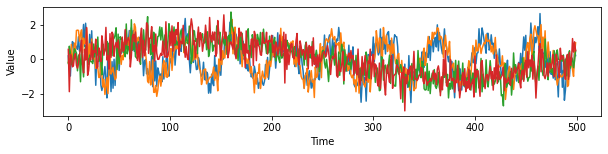

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
# import warnings
# warnings.filterwarnings('ignore')
T = 500 # sequence length
observations = 2*np.sin(np.linspace(0, 20*np.pi, T))
interventions = 2*np.sin(np.linspace(0, 2*np.pi, T))
data = np.vstack([observations, observations*1.2, interventions,
  interventions*0.85]).T
data += np.random.randn(*data.shape)
# data[:, 2:] = preprocessing.minmax_scale(data[:, 2:])
data = scale(data)

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [7]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [8]:
dkf = DKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=20)

In [9]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 4.165, mse= 3.813, kld= 3.522
	val_loss= 4.113, val_mse= 3.846, val_kld= 2.674
Epoch= 2/200, loss= 3.926, mse= 3.658, kld= 2.682
	val_loss= 3.639, val_mse= 3.424, val_kld= 2.151
Epoch= 3/200, loss= 4.056, mse= 3.834, kld= 2.218
	val_loss= 4.394, val_mse= 4.210, val_kld= 1.840
Epoch= 4/200, loss= 3.815, mse= 3.638, kld= 1.767
	val_loss= 3.438, val_mse= 3.293, val_kld= 1.454
Epoch= 5/200, loss= 3.800, mse= 3.648, kld= 1.515
	val_loss= 3.977, val_mse= 3.859, val_kld= 1.184
Epoch= 6/200, loss= 3.704, mse= 3.577, kld= 1.270
	val_loss= 4.117, val_mse= 4.016, val_kld= 1.014
Epoch= 7/200, loss= 3.868, mse= 3.758, kld= 1.097
	val_loss= 3.834, val_mse= 3.750, val_kld= 0.845
Epoch= 8/200, loss= 3.729, mse= 3.636, kld= 0.934
	val_loss= 4.201, val_mse= 4.126, val_kld= 0.750
Epoch= 9/200, loss= 3.525, mse= 3.449, kld= 0.765
	val_loss= 3.113, val_mse= 3.052, val_kld= 0.612
Epoch= 10/200, loss= 3.520, mse= 3.456, kld= 0.641
	val_loss= 4.235, val_mse= 4.184, val_kld= 0.511
Epoch= 11

<AxesSubplot:xlabel='Epoch'>

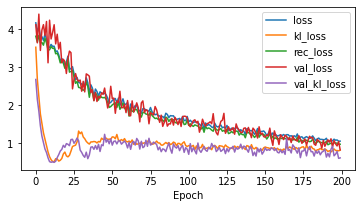

In [10]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

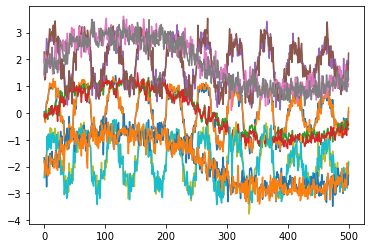

In [11]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

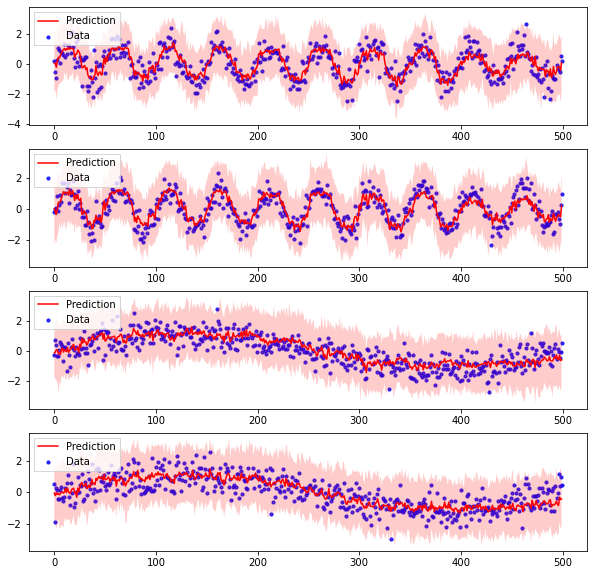

In [12]:
fig, ax = plt.subplots(4, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

# Moja praca

## Wczytanie danych

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import torch

In [14]:


#FIRST on 10 000 workouts - train 9000, test 1000
data_endo = []
i = 0
#with gzip.open('endomondoHR.json.gz') as f:

with open('endomondoHR_proper.json') as f:
    for l in f:
        i += 1
        #print(i)
        data_endo.append(eval(l))
        if i == 10000:
            break
        #print(data[0])

## Wstępne wykresy

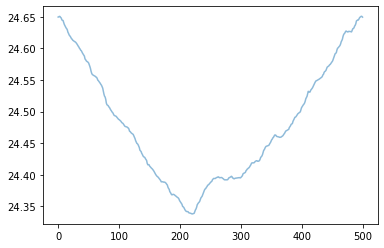

In [15]:

# Plot ithmeasurement x longitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

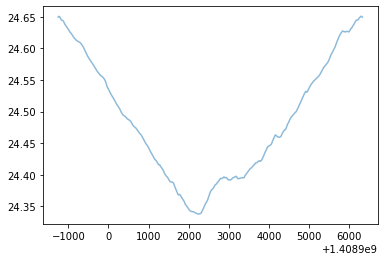

In [16]:

# Plot timestamp x longitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)


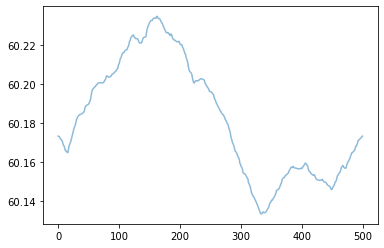

In [17]:

# Plot ithmeasurement x latitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['latitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

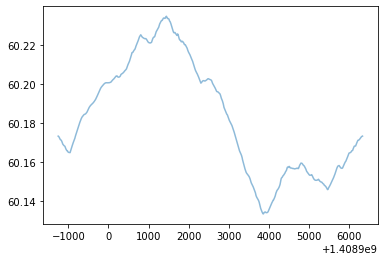

In [18]:

# Plot timestamp x latitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['latitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)


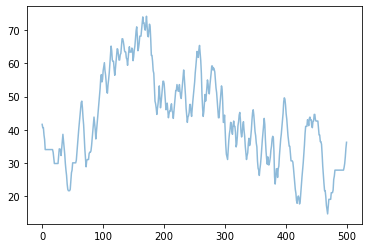

In [19]:

# Plot ithmeasurement x altitude

#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['altitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

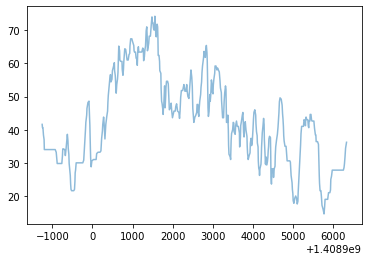

In [20]:

# Plot timestamp x altitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['altitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

In [21]:
####OK wykresy sie zgadzaja

In [22]:
###TERAZ TRENUJEMY DLA 1 WORKOUTU LONGITUDE,TRAIN TO PIERWSZE 450 A VAL TO KOLEJNE 50

In [23]:
#### ITHMEASUREMENT vs LONGITUDE

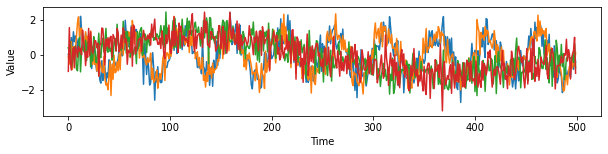

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
# import warnings
# warnings.filterwarnings('ignore')
T = 500 # sequence length
observations = 2*np.sin(np.linspace(0, 20*np.pi, T))
interventions = 2*np.sin(np.linspace(0, 2*np.pi, T))
data = np.vstack([observations, observations*1.2, interventions,
  interventions*0.85]).T
data += np.random.randn(*data.shape)
# data[:, 2:] = preprocessing.minmax_scale(data[:, 2:])
data = scale(data)

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [25]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)
#print(data.shape[1])

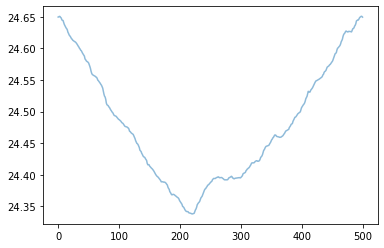

In [26]:

# Plot ithmeasurement x longitude



#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

## Trenowane dla 1 treningo po longitude

In [27]:
#x = torch.FloatTensor(data).reshape(1, *data.shape)
#x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])

y_data = torch.FloatTensor(y).reshape(1, 500, 1)
#print(y_data)
y_train = torch.FloatTensor(y[:450]).reshape(1, 450, 1)
#print(y_train)
y_val = torch.FloatTensor(y[450:500]).reshape(1, 50, 1)
#print(y_val)


In [28]:
dkf = DKF(input_dim=1, z_dim=5, rnn_dim=5, trans_dim=5, emission_dim=5)

In [29]:
history = dkf.fit(y_train, y_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 623.502, mse= 622.434, kld= 10.678
	val_loss= 628.710, val_mse= 627.745, val_kld= 9.648
Epoch= 2/200, loss= 620.764, mse= 619.829, kld= 9.355
	val_loss= 615.407, val_mse= 614.366, val_kld= 10.413
Epoch= 3/200, loss= 609.827, mse= 608.923, kld= 9.033
	val_loss= 619.962, val_mse= 618.906, val_kld= 10.559
Epoch= 4/200, loss= 608.921, mse= 608.013, kld= 9.082
	val_loss= 603.227, val_mse= 602.252, val_kld= 9.755
Epoch= 5/200, loss= 604.954, mse= 604.033, kld= 9.206
	val_loss= 614.298, val_mse= 613.286, val_kld= 10.122
Epoch= 6/200, loss= 594.278, mse= 593.298, kld= 9.794
	val_loss= 608.894, val_mse= 607.912, val_kld= 9.813
Epoch= 7/200, loss= 592.985, mse= 591.931, kld= 10.535
	val_loss= 584.061, val_mse= 582.905, val_kld= 11.561
Epoch= 8/200, loss= 582.421, mse= 581.320, kld= 11.016
	val_loss= 559.898, val_mse= 558.628, val_kld= 12.704
Epoch= 9/200, loss= 571.424, mse= 570.216, kld= 12.074
	val_loss= 550.856, val_mse= 549.603, val_kld= 12.536
Epoch= 10/200, loss= 551.19

<AxesSubplot:xlabel='Epoch'>

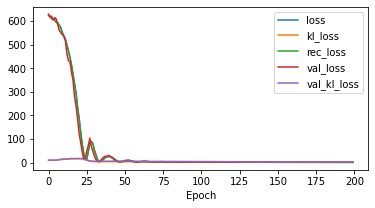

In [30]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

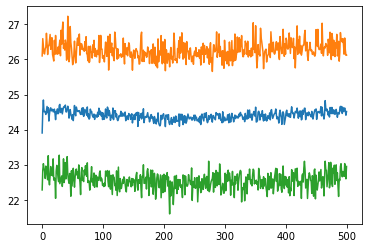

In [31]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(y_data, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

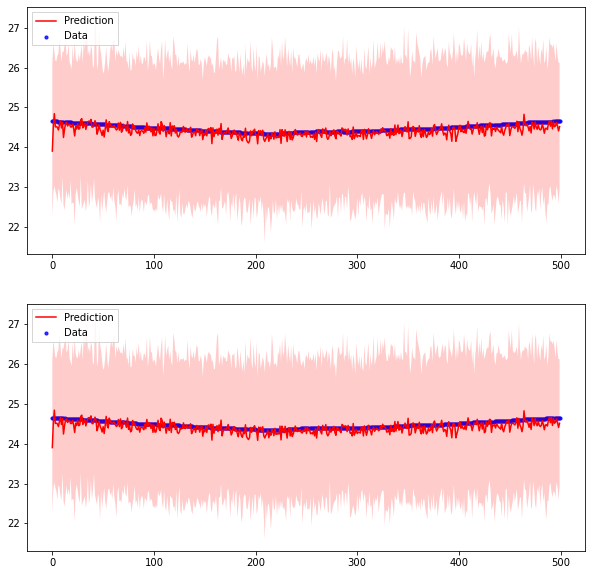

In [32]:
fig, ax = plt.subplots(2, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(y.shape[0]),
        y[:], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, 0], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, 0], x_975[:, 0],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [36]:

mse_values = mean_squared_error(y_data[0], x_hat)
r_squared_values = r2_score(y_data[0], x_hat)
mae_values = mean_absolute_error(y_data[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(y_data[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(y_data[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(y_data[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

print(x_hat.shape)

              MSE  R-squared       MAE
Average  0.016395  -0.940467  0.101313
              MSE  R-squared       MAE
sample1  0.016395  -0.940467  0.101313
(500, 1)


In [37]:
###################################################################################################################

In [38]:
####################################################################################################################

In [39]:
#TUTAJ TRENUJEMY DKF'a dla 1szego WORKOUTU 3 na RAZ LON LAT ALT

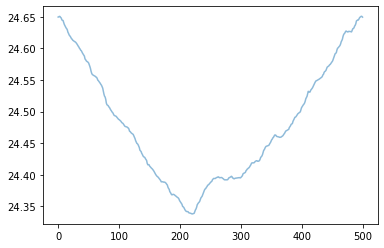

(500, 3)


In [49]:

# Plot ithmeasurement x longitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)





first_workout_data = np.vstack([np.asarray(data_endo[0]['longitude']), np.asarray(data_endo[0]['latitude']), np.asarray(data_endo[0]['altitude'])]).T
print(first_workout_data.shape)

## Trenowane dla pierwszego treningu po longitude, latitude i altitude

In [53]:
x = torch.FloatTensor(first_workout_data).reshape(1, *first_workout_data.shape)
#print(x)
x_train = torch.FloatTensor(first_workout_data[:450]).reshape(1, 450, first_workout_data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(first_workout_data[450:500]).reshape(1, 50, first_workout_data.shape[1])
#print(x_val)

In [54]:
dkf = DKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

In [55]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 2146.235, mse= 2144.107, kld= 21.282
	val_loss= 1662.247, val_mse= 1660.774, val_kld= 14.722
Epoch= 2/200, loss= 2123.499, mse= 2121.992, kld= 15.068
	val_loss= 1660.801, val_mse= 1659.088, val_kld= 17.127
Epoch= 3/200, loss= 2097.051, mse= 2095.584, kld= 14.663
	val_loss= 1614.985, val_mse= 1613.058, val_kld= 19.273
Epoch= 4/200, loss= 2048.734, mse= 2047.065, kld= 16.684
	val_loss= 1547.456, val_mse= 1545.416, val_kld= 20.400
Epoch= 5/200, loss= 1970.339, mse= 1968.589, kld= 17.510
	val_loss= 1419.559, val_mse= 1417.389, val_kld= 21.701
Epoch= 6/200, loss= 1839.277, mse= 1837.466, kld= 18.110
	val_loss= 1254.884, val_mse= 1252.091, val_kld= 27.926
Epoch= 7/200, loss= 1643.484, mse= 1641.286, kld= 21.975
	val_loss= 989.350, val_mse= 985.604, val_kld= 37.454
Epoch= 8/200, loss= 1343.773, mse= 1340.456, kld= 33.171
	val_loss= 634.403, val_mse= 629.168, val_kld= 52.349
Epoch= 9/200, loss= 917.432, mse= 910.675, kld= 67.566
	val_loss= 289.974, val_mse= 282.965, val_kld

<AxesSubplot:xlabel='Epoch'>

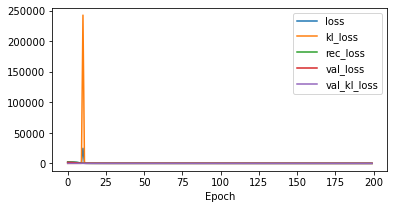

In [56]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

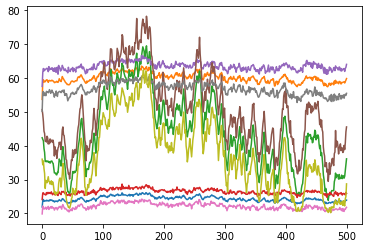

In [57]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

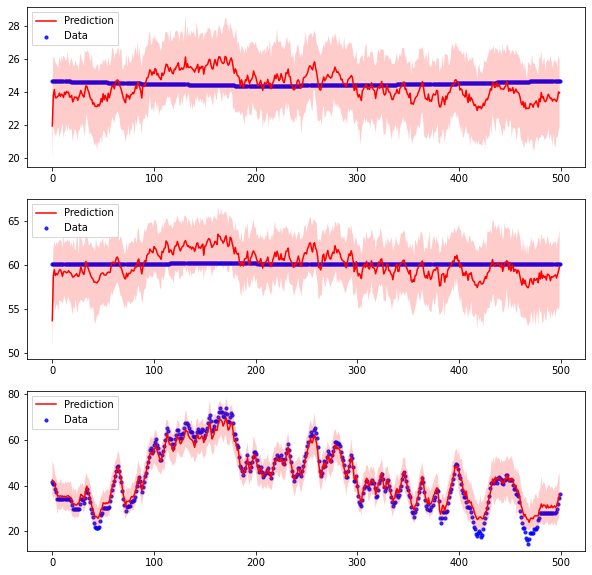

In [58]:
fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(first_workout_data.shape[0]),
        first_workout_data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [59]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

             MSE   R-squared       MAE
Average  3.05994 -715.162791  1.266711
              MSE    R-squared       MAE
sample1  0.702767   -82.176372  0.709903
sample2  1.852187 -2064.275520  1.117837
sample3  6.624866     0.963519  1.972394


In [60]:
###################################################################################################################

In [61]:
####################################################################################################################

In [62]:
#TERAZ DKF DLA LONGITUDE DLA 3 PIERWSZYCH WORKOUTOW

## Trenowane dla 3 pierwszych treningow po longitude

In [63]:
longitude_three_data = np.vstack([np.asarray(data_endo[0]['longitude']), np.asarray(data_endo[1]['longitude']), np.asarray(data_endo[2]['longitude'])]).T
#print(first_workout_data.shape)

In [64]:
x = torch.FloatTensor(longitude_three_data).reshape(1, *longitude_three_data.shape)
#print(x)
x_train = torch.FloatTensor(longitude_three_data[:450]).reshape(1, 450, longitude_three_data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(longitude_three_data[450:500]).reshape(1, 50, longitude_three_data.shape[1])
#print(x_val)

In [65]:
dkf = DKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

In [66]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 615.424, mse= 611.048, kld= 43.759
	val_loss= 612.800, val_mse= 611.577, val_kld= 12.232
Epoch= 2/200, loss= 604.132, mse= 602.924, kld= 12.086
	val_loss= 595.655, val_mse= 594.903, val_kld= 7.517
Epoch= 3/200, loss= 597.536, mse= 596.765, kld= 7.708
	val_loss= 599.358, val_mse= 598.641, val_kld= 7.164
Epoch= 4/200, loss= 588.115, mse= 587.436, kld= 6.785
	val_loss= 598.389, val_mse= 597.586, val_kld= 8.026
Epoch= 5/200, loss= 581.689, mse= 580.905, kld= 7.840
	val_loss= 581.217, val_mse= 580.199, val_kld= 10.177
Epoch= 6/200, loss= 569.804, mse= 568.812, kld= 9.922
	val_loss= 564.056, val_mse= 562.664, val_kld= 13.919
Epoch= 7/200, loss= 553.542, mse= 552.213, kld= 13.292
	val_loss= 523.680, val_mse= 521.459, val_kld= 22.204
Epoch= 8/200, loss= 517.718, mse= 515.592, kld= 21.256
	val_loss= 496.084, val_mse= 492.163, val_kld= 39.214
Epoch= 9/200, loss= 473.373, mse= 469.947, kld= 34.258
	val_loss= 426.303, val_mse= 420.724, val_kld= 55.796
Epoch= 10/200, loss= 416.7

<AxesSubplot:xlabel='Epoch'>

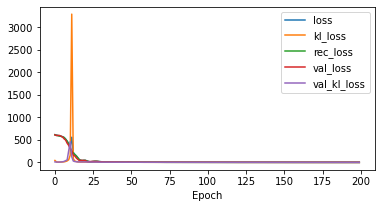

In [67]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

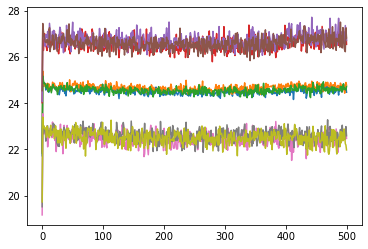

In [68]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

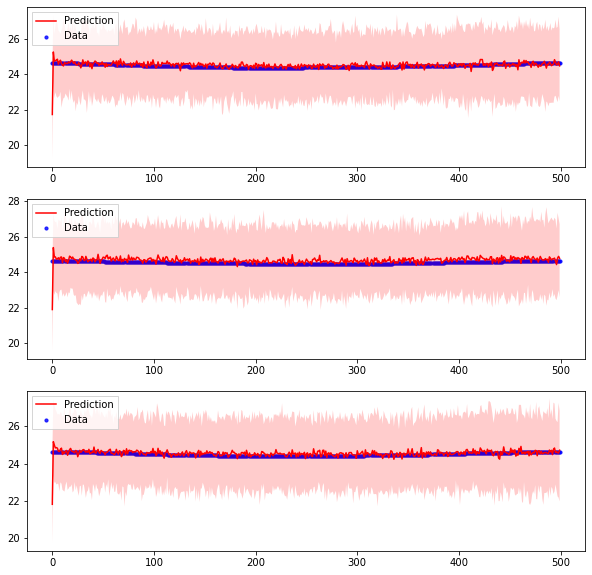

In [69]:
fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(longitude_three_data.shape[0]),
        longitude_three_data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [70]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

              MSE  R-squared       MAE
Average  0.038147  -6.163188  0.124432
              MSE  R-squared       MAE
sample1  0.033816  -3.002260  0.107933
sample2  0.047257 -11.485013  0.156687
sample3  0.033368  -4.002292  0.108678


In [71]:
####################################################################################################################

In [72]:
####################################################################################################################

In [73]:
#TUTAJ DKF PO ALTITUDE DLA 5 WORKOUTOW

## Trenowane dla 5 pierwszych treningow po altitude

In [74]:
data = np.vstack([np.asarray(data_endo[0]['altitude']), np.asarray(data_endo[1]['altitude']), 
                  np.asarray(data_endo[2]['altitude']), np.asarray(data_endo[3]['altitude']),
                  np.asarray(data_endo[4]['altitude'])]).T
#print(data.shape)

In [75]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:450]).reshape(1, 450, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[450:500]).reshape(1, 50, data.shape[1])
#print(x_val)

In [76]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

In [77]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 2056.193, mse= 1997.906, kld= 582.867
	val_loss= 837.375, val_mse= 834.700, val_kld= 26.746
Epoch= 2/200, loss= 1970.979, mse= 1964.195, kld= 67.842
	val_loss= 854.156, val_mse= 852.582, val_kld= 15.744
Epoch= 3/200, loss= 1959.234, mse= 1955.947, kld= 32.875
	val_loss= 820.058, val_mse= 818.859, val_kld= 11.988
Epoch= 4/200, loss= 1936.529, mse= 1934.269, kld= 22.598
	val_loss= 819.164, val_mse= 817.934, val_kld= 12.305
Epoch= 5/200, loss= 1889.502, mse= 1887.372, kld= 21.304
	val_loss= 770.426, val_mse= 768.967, val_kld= 14.586
Epoch= 6/200, loss= 1808.698, mse= 1805.763, kld= 29.350
	val_loss= 706.895, val_mse= 704.894, val_kld= 20.013
Epoch= 7/200, loss= 1658.816, mse= 1654.206, kld= 46.102
	val_loss= 589.957, val_mse= 586.901, val_kld= 30.562
Epoch= 8/200, loss= 1398.010, mse= 1390.014, kld= 79.958
	val_loss= 400.964, val_mse= 396.124, val_kld= 48.402
Epoch= 9/200, loss= 973.259, mse= 951.386, kld= 218.735
	val_loss= 171.708, val_mse= 165.642, val_kld= 60.664
E

<AxesSubplot:xlabel='Epoch'>

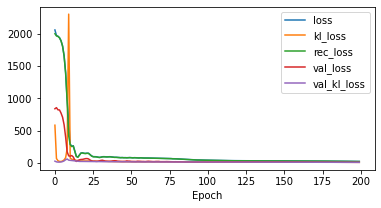

In [78]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

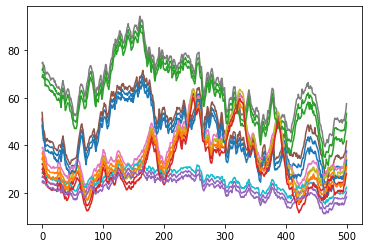

In [79]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

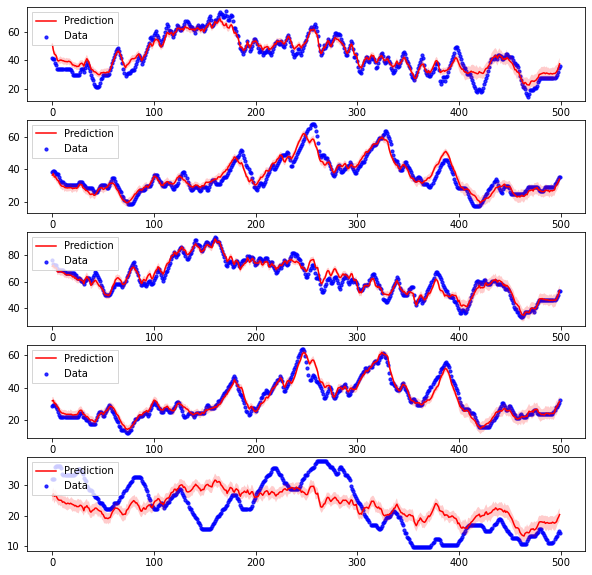

In [80]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [81]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared       MAE
Average  18.637676   0.802638  3.278583
               MSE  R-squared       MAE
sample1  16.057415   0.911578  3.159955
sample2  10.906034   0.898702  2.669766
sample3  10.822713   0.938051  2.632434
sample4   8.099045   0.937871  2.136920
sample5  47.303181   0.326990  5.793841


In [82]:
####################################################################################################################

In [83]:
#Preparing test synthetic datasets - each 1000 measurements

# Przygotowanie danych syntetycznych

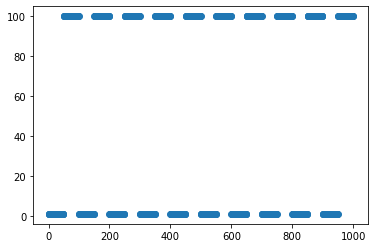

In [84]:
#Dataset 1 - binary a bunch of 1's then a bunch of 100's
data_bin = []
while len(data_bin)<1000:
    data_bin.extend([1 for i in range(50)])
    data_bin.extend([100 for i in range(50)])
data_bin = np.asarray(data_bin[:1000])
#print(data_bin)
plt.scatter(range(len(data_bin)),data_bin)
plt.show()



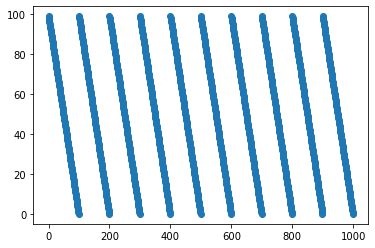

In [85]:
#Dataset 2 - Decreasing from 100 to 1 in a loop
data_spike = []
while len(data_spike)<1000:
    data_spike.extend([-i + 100 for i in range(1, 101)])
    
data_spike = np.asarray(data_spike[:1000])
#print(data_spike)
plt.scatter(range(len(data_spike)), data_spike)
plt.show()

In [86]:
#Dataset 3 - Growing from 1 to 100 then from 100 to 1

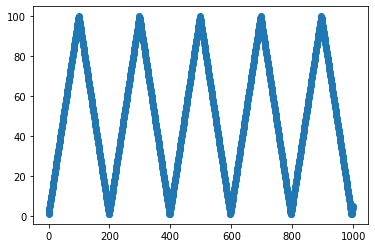

In [87]:
data_alt = []
while len(data_alt)<1000:
    data_alt.extend([i for i in range(1,100)])
    data_alt.extend([i for i in range(100,0,-1)])
    
data_alt = np.asarray(data_alt[:1000])
#print(data_alt)
plt.scatter(range(len(data_alt)), data_alt)
plt.show()

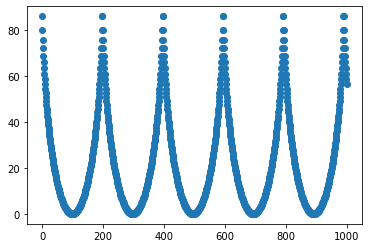

In [88]:
#Dataset 4 - Lower half of a circle
data_circle = []
while len(data_circle)<1000:
    data_circle.extend([-np.sqrt(100 ** 2 - i ** 2) + 100 for i in range(99,0,-1)])
    data_circle.extend([-np.sqrt(100 ** 2 - i ** 2) + 100 for i in range(1,100)])
    
data_circle = np.asarray(data_circle[:1000])
#print(data_circle)
#print(len(data_circle))
plt.scatter(range(len(data_circle)), data_circle)
plt.show()

In [89]:
data = np.vstack([data_bin, data_spike, data_alt, data_circle]).T
#print(data.shape)

In [90]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:600]).reshape(1, 600, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[600:800]).reshape(1, 200, data.shape[1])
#print(x_val)

## Trenowanie dla danych syntetycznych

In [91]:
dkf = DKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=20)

In [92]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

Epoch= 1/200, loss= 3201.422, mse= 3130.656, kld= 353.830
	val_loss= 3114.693, val_mse= 3104.299, val_kld= 51.970
Epoch= 2/200, loss= 3118.659, mse= 3107.633, kld= 55.130
	val_loss= 3075.687, val_mse= 3069.776, val_kld= 29.556
Epoch= 3/200, loss= 3072.351, mse= 3066.351, kld= 29.999
	val_loss= 3014.176, val_mse= 3009.399, val_kld= 23.888
Epoch= 4/200, loss= 3019.094, mse= 3014.293, kld= 24.006
	val_loss= 2932.756, val_mse= 2928.168, val_kld= 22.939
Epoch= 5/200, loss= 2928.071, mse= 2923.459, kld= 23.058
	val_loss= 2783.079, val_mse= 2778.054, val_kld= 25.123
Epoch= 6/200, loss= 2779.789, mse= 2774.680, kld= 25.544
	val_loss= 2551.224, val_mse= 2544.906, val_kld= 31.593
Epoch= 7/200, loss= 2558.308, mse= 2551.885, kld= 32.114
	val_loss= 2232.368, val_mse= 2223.863, val_kld= 42.528
Epoch= 8/200, loss= 2237.377, mse= 2228.795, kld= 42.913
	val_loss= 1812.520, val_mse= 1802.177, val_kld= 51.715
Epoch= 9/200, loss= 1820.915, mse= 1810.445, kld= 52.347
	val_loss= 1455.393, val_mse= 1444.568

<AxesSubplot:xlabel='Epoch'>

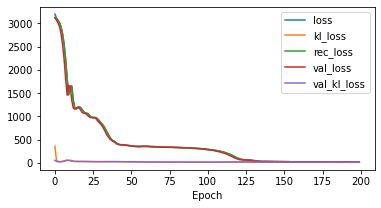

In [93]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

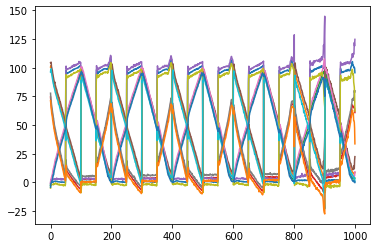

In [94]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

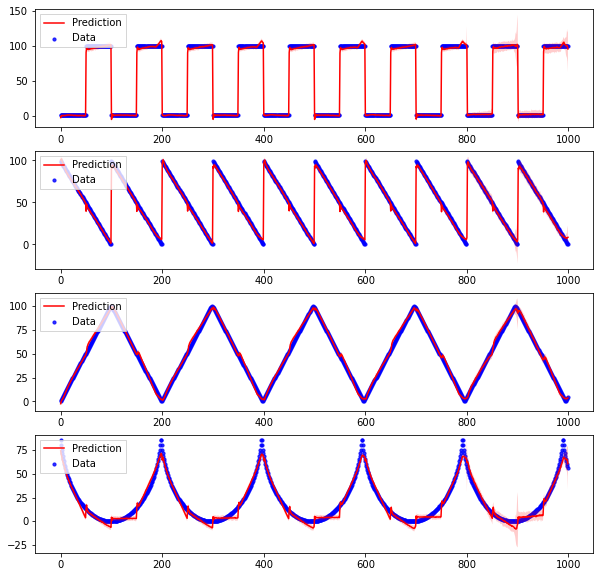

In [95]:
fig, ax = plt.subplots(4, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [96]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared       MAE
Average  22.682325   0.976989  2.133317
               MSE  R-squared       MAE
sample1  43.909302   0.982080  1.982381
sample2  20.199953   0.975758  1.305262
sample3   5.018407   0.993969  1.798923
sample4  21.601639   0.956149  3.446701


In [97]:
#################################################################################

# Przesuniecie i normalizacja danych

## Trenowanie dla pierwszych 5 treningow po przesunieciu w plaszczyznie longitude x latitude

In [148]:
#5 Workoutow, gdzie zbijamy longitude i latitude w przesuniecie



def translation(i):
    lon = np.asarray(data_endo[i]['longitude'])
    lat = np.asarray(data_endo[i]['latitude'])
    tra = np.sqrt(np.power(lon, 2) + np.power(lat,2))
    return tra

data = np.vstack( [translation(i) for i in range(5)]).T
#print(data.shape)

In [149]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [150]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

In [151]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

Epoch= 1/200, loss= 5021.871, mse= 4327.338, kld= 3472.661
	val_loss= 4272.162, val_mse= 4227.708, val_kld= 222.268
Epoch= 2/200, loss= 4251.182, mse= 4210.177, kld= 205.026
	val_loss= 4151.561, val_mse= 4139.976, val_kld= 57.925
Epoch= 3/200, loss= 4165.225, mse= 4155.021, kld= 51.018
	val_loss= 4091.903, val_mse= 4085.657, val_kld= 31.226
Epoch= 4/200, loss= 4091.023, mse= 4086.004, kld= 25.091
	val_loss= 4013.992, val_mse= 4008.427, val_kld= 27.828
Epoch= 5/200, loss= 4004.229, mse= 3999.907, kld= 21.609
	val_loss= 3892.824, val_mse= 3886.973, val_kld= 29.256
Epoch= 6/200, loss= 3883.549, mse= 3879.116, kld= 22.168
	val_loss= 3712.172, val_mse= 3706.094, val_kld= 30.393
Epoch= 7/200, loss= 3708.919, mse= 3704.403, kld= 22.581
	val_loss= 3458.956, val_mse= 3452.419, val_kld= 32.689
Epoch= 8/200, loss= 3448.700, mse= 3443.819, kld= 24.402
	val_loss= 3090.984, val_mse= 3083.267, val_kld= 38.585
Epoch= 9/200, loss= 3067.508, mse= 3061.731, kld= 28.883
	val_loss= 2495.056, val_mse= 2485.

<AxesSubplot:xlabel='Epoch'>

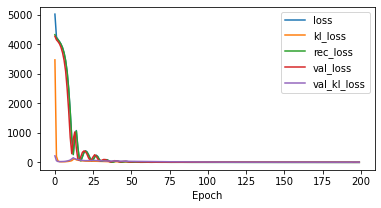

In [152]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

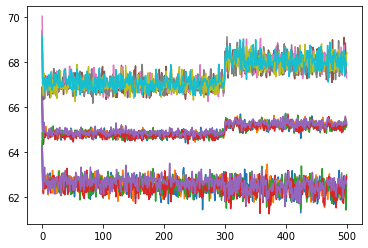

In [153]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

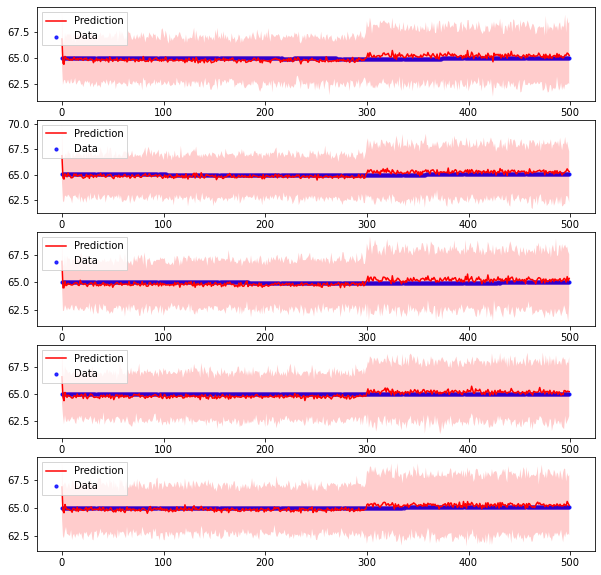

In [154]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [155]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

              MSE  R-squared       MAE
Average  0.066287 -86.273692  0.213257
              MSE   R-squared       MAE
sample1  0.073790  -59.503678  0.226607
sample2  0.066003  -98.274881  0.210639
sample3  0.070706  -51.447325  0.218205
sample4  0.063996  -97.830811  0.213915
sample5  0.056939 -124.311765  0.196918


In [106]:
##########################################################################################################

## Trenowane dla znormalizowanych latitude i longitude

In [164]:
#Normalizacja dla 2D - latitude i longitude


def NormalizeData(data):
    return 100*(data - np.min(data)) / (np.max(data) - np.min(data))

norm_long = NormalizeData(np.asarray(data_endo[0]['longitude']))
norm_lat  = NormalizeData(np.asarray(data_endo[0]['latitude']))
#norm_alt  = NormalizeData(np.asarray(data_endo[0]['altitude']))

data = np.vstack([norm_long, norm_lat]).T
#print(data.shape)


In [165]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [166]:
dkf = DKF(input_dim=2, z_dim=10, rnn_dim=10, trans_dim=10, emission_dim=10)

In [167]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 2951.264, mse= 2947.198, kld= 40.664
	val_loss= 2412.805, val_mse= 2409.479, val_kld= 33.263
Epoch= 2/200, loss= 2940.169, mse= 2937.394, kld= 27.749
	val_loss= 2413.620, val_mse= 2410.670, val_kld= 29.501
Epoch= 3/200, loss= 2928.881, mse= 2925.472, kld= 34.096
	val_loss= 2417.313, val_mse= 2414.032, val_kld= 32.807
Epoch= 4/200, loss= 2900.527, mse= 2895.451, kld= 50.765
	val_loss= 2345.349, val_mse= 2341.521, val_kld= 38.278
Epoch= 5/200, loss= 2874.516, mse= 2866.608, kld= 79.080
	val_loss= 2338.229, val_mse= 2333.089, val_kld= 51.400
Epoch= 6/200, loss= 2815.988, mse= 2802.191, kld= 137.966
	val_loss= 2259.210, val_mse= 2252.296, val_kld= 69.139
Epoch= 7/200, loss= 2761.458, mse= 2722.736, kld= 387.219
	val_loss= 2170.377, val_mse= 2161.880, val_kld= 84.969
Epoch= 8/200, loss= 2639.299, mse= 2582.464, kld= 568.349
	val_loss= 2098.459, val_mse= 2092.504, val_kld= 59.547
Epoch= 9/200, loss= 2531.204, mse= 2505.422, kld= 257.820
	val_loss= 2016.346, val_mse= 2011.

<AxesSubplot:xlabel='Epoch'>

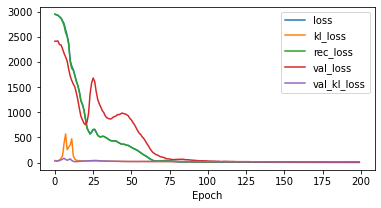

In [168]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

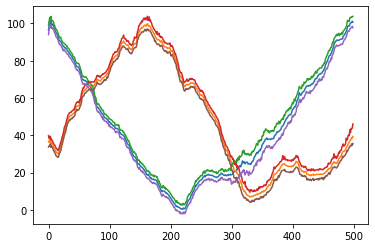

In [169]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

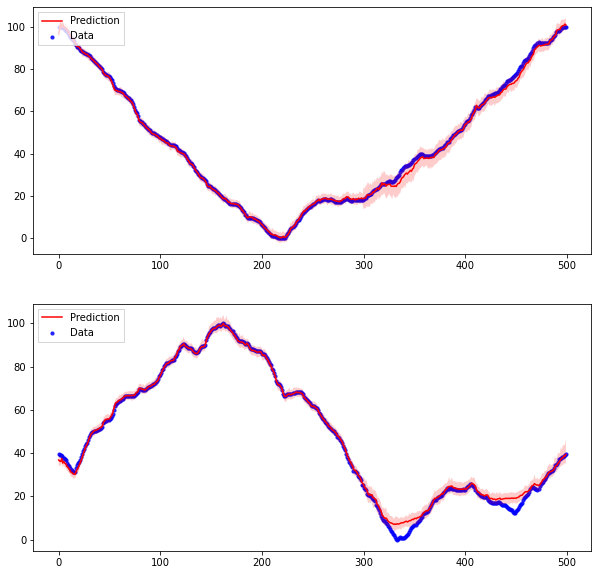

In [170]:
fig, ax = plt.subplots(2, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [171]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

              MSE  R-squared       MAE
Average  2.396398    0.99724  0.914941
              MSE  R-squared       MAE
sample1  1.511018   0.998245  0.815713
sample2  3.281777   0.996235  1.014170


In [115]:
#Normalizacja dla 3D - latitude, longitude i altitude

## Trenowanie dla znormalizowanych danych latitude, longitude, altitude

In [180]:
def NormalizeData(data):
    return 100*(data - np.min(data)) / (np.max(data) - np.min(data))

norm_long = NormalizeData(np.asarray(data_endo[0]['longitude']))
norm_lat  = NormalizeData(np.asarray(data_endo[0]['latitude']))
norm_alt  = NormalizeData(np.asarray(data_endo[0]['altitude']))

data = np.vstack([norm_long, norm_lat, norm_alt]).T
#print(data.shape)


In [181]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [182]:
dkf = DKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

In [183]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.15)

Epoch= 1/200, loss= 3075.490, mse= 3065.214, kld= 68.504
	val_loss= 2062.333, val_mse= 2059.936, val_kld= 15.985
Epoch= 2/200, loss= 3053.789, mse= 3049.859, kld= 26.197
	val_loss= 2042.790, val_mse= 2040.794, val_kld= 13.311
Epoch= 3/200, loss= 3049.876, mse= 3047.372, kld= 16.695
	val_loss= 2008.748, val_mse= 2006.536, val_kld= 14.751
Epoch= 4/200, loss= 3018.990, mse= 3016.834, kld= 14.375
	val_loss= 1996.012, val_mse= 1993.320, val_kld= 17.944
Epoch= 5/200, loss= 2983.377, mse= 2981.067, kld= 15.397
	val_loss= 1934.500, val_mse= 1931.190, val_kld= 22.073
Epoch= 6/200, loss= 2914.447, mse= 2911.724, kld= 18.149
	val_loss= 1819.334, val_mse= 1815.969, val_kld= 22.435
Epoch= 7/200, loss= 2830.814, mse= 2827.517, kld= 21.982
	val_loss= 1656.322, val_mse= 1652.179, val_kld= 27.618
Epoch= 8/200, loss= 2659.500, mse= 2655.144, kld= 29.042
	val_loss= 1393.335, val_mse= 1386.052, val_kld= 48.555
Epoch= 9/200, loss= 2390.669, mse= 2382.922, kld= 51.650
	val_loss= 1084.684, val_mse= 1072.188,

<AxesSubplot:xlabel='Epoch'>

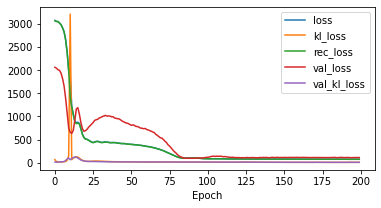

In [184]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

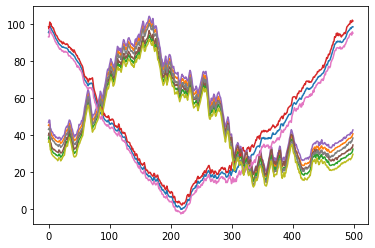

In [185]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

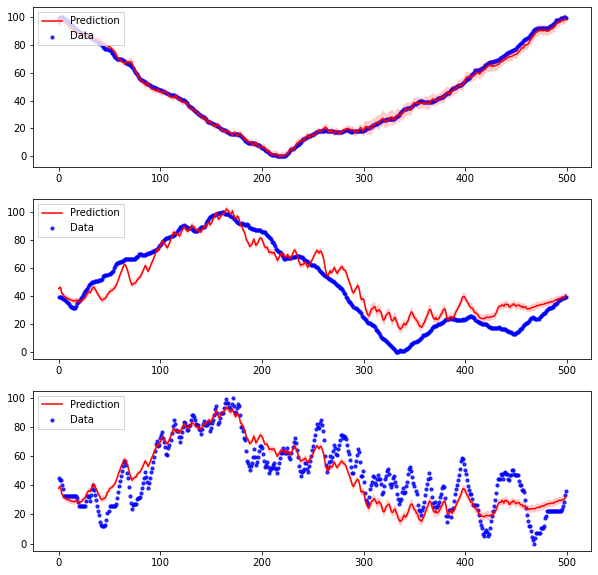

In [186]:
fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [123]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared       MAE
Average  81.001808   0.876973  6.943033
                MSE  R-squared       MAE
sample1   87.447861   0.898425  6.845865
sample2   45.457722   0.947852  5.473374
sample3  110.099846   0.784641  8.509858


In [124]:
############################################################################################################

In [125]:
#5 Workoutow ze znormalizowanym altitude

## 5 treningow z znormalizowanym altitude

In [126]:
def NormalizeData(data):
    return 100*(data - np.min(data)) / (np.max(data) - np.min(data))
data = [np.asarray(data_endo[i]['altitude']) for i in range(5)]
data = np.asarray(data).T
data = NormalizeData(data)

#data = np.vstack([NormalizeData(np.asarray(data_endo[i]['altitude'])) for i in range(5)]).T
#print(data.shape)


In [127]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [128]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

In [129]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.15)

Epoch= 1/200, loss= 2474.921, mse= 1892.412, kld= 3883.389
	val_loss= 891.818, val_mse= 886.852, val_kld= 33.102
Epoch= 2/200, loss= 1887.446, mse= 1876.169, kld= 75.177
	val_loss= 869.975, val_mse= 865.804, val_kld= 27.807
Epoch= 3/200, loss= 1853.118, mse= 1843.461, kld= 64.384
	val_loss= 844.317, val_mse= 839.910, val_kld= 29.380
Epoch= 4/200, loss= 1815.837, mse= 1806.370, kld= 63.116
	val_loss= 827.746, val_mse= 822.935, val_kld= 32.075
Epoch= 5/200, loss= 1748.147, mse= 1736.224, kld= 79.485
	val_loss= 757.746, val_mse= 750.973, val_kld= 45.155
Epoch= 6/200, loss= 1610.316, mse= 1589.881, kld= 136.235
	val_loss= 655.637, val_mse= 644.329, val_kld= 75.392
Epoch= 7/200, loss= 1350.554, mse= 1302.316, kld= 321.585
	val_loss= 504.103, val_mse= 483.811, val_kld= 135.282
Epoch= 8/200, loss= 132715.141, mse= 733.612, kld= 879876.812
	val_loss= 418.413, val_mse= 408.654, val_kld= 65.065
Epoch= 9/200, loss= 775.093, mse= 743.574, kld= 210.126
	val_loss= 352.857, val_mse= 346.867, val_kld=

<AxesSubplot:xlabel='Epoch'>

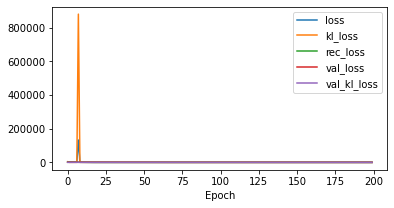

In [130]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

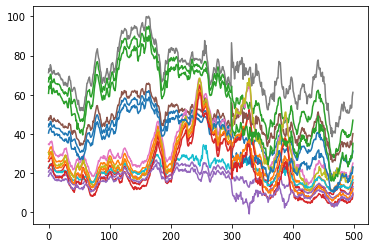

In [131]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

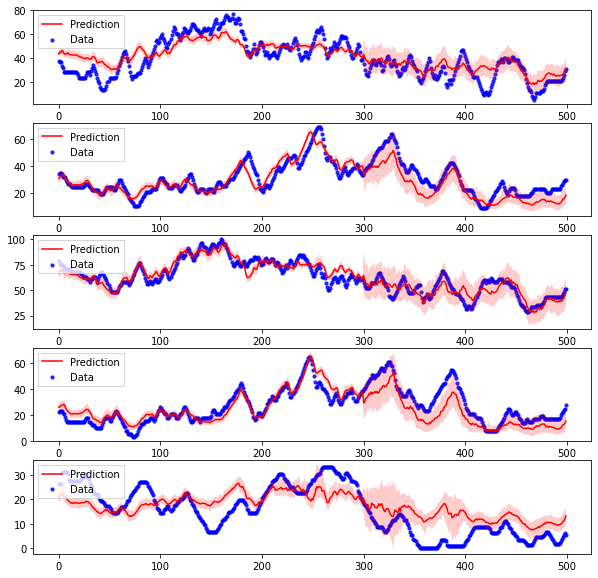

In [132]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [133]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared     MAE
Average  56.690693   0.668064  6.0823
               MSE  R-squared       MAE
sample1  88.189804   0.655708  7.648841
sample2  43.054741   0.716482  5.216280
sample3  39.288868   0.840561  5.148287
sample4  57.348969   0.688104  6.037360
sample5  55.571079   0.439463  6.360728


## Syntetyczne zaszumione

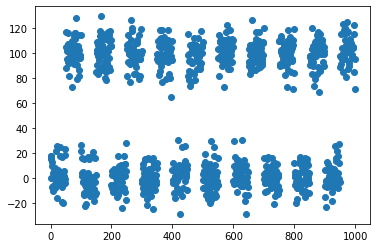

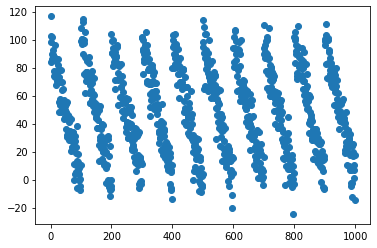

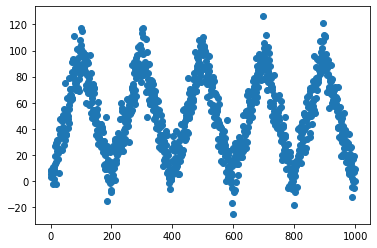

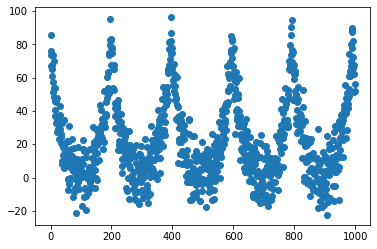

In [134]:
#Dataset 1 - binary a bunch of 1's then a bunch of 100's
data_bin = []
while len(data_bin)<1000:
    data_bin.extend([1 for i in range(50)])
    data_bin.extend([100 for i in range(50)])
data_bin = np.asarray(data_bin[:1000]) 
data_bin =  data_bin + np.random.normal(0, 10, size = data_bin.shape)
#print(data_bin)
plt.scatter(range(len(data_bin)),data_bin)
plt.show()



#Dataset 2 - Decreasing from 100 to 1 in a loop
data_spike = []
while len(data_spike)<1000:
    data_spike.extend([-i + 100 for i in range(1, 101)])
    
data_spike = np.asarray(data_spike[:1000])
data_spike = data_spike + np.random.normal(0,10, size = data_spike.shape)
#print(data_spike)
plt.scatter(range(len(data_spike)), data_spike)
plt.show()

#Dataset 3 - Growing from 1 to 100 then from 100 to 1

data_alt = []
while len(data_alt)<1000:
    data_alt.extend([i for i in range(1,100)])
    data_alt.extend([i for i in range(100,0,-1)])
    
data_alt = np.asarray(data_alt[:1000])
data_alt = data_alt + np.random.normal(0, 10, size = data_alt.shape)
#print(data_alt)
plt.scatter(range(len(data_alt)), data_alt)
plt.show()

#Dataset 4 - Lower half of a circle
data_circle = []
while len(data_circle)<1000:
    data_circle.extend([-np.sqrt(100 ** 2 - i ** 2) + 100 for i in range(99,0,-1)])
    data_circle.extend([-np.sqrt(100 ** 2 - i ** 2) + 100 for i in range(1,100)])
    
data_circle = np.asarray(data_circle[:1000])
data_circle = data_circle + np.random.normal(0, 10, size = data_circle.shape)
#print(data_circle)
#print(len(data_circle))
plt.scatter(range(len(data_circle)), data_circle)
plt.show()

data = np.vstack([data_bin, data_spike, data_alt, data_circle]).T
#print(data.shape)

x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:600]).reshape(1, 600, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[600:800]).reshape(1, 200, data.shape[1])
#print(x_val)



Epoch= 1/200, loss= inf, mse= 3091.365, kld= inf
	val_loss= nan, val_mse= nan, val_kld= nan
Epoch= 2/200, loss= nan, mse= nan, kld= nan
	val_loss= nan, val_mse= nan, val_kld= nan
Epoch= 3/200, loss= nan, mse= nan, kld= nan
	val_loss= nan, val_mse= nan, val_kld= nan
Epoch= 4/200, loss= nan, mse= nan, kld= nan
	val_loss= nan, val_mse= nan, val_kld= nan
Epoch= 5/200, loss= nan, mse= nan, kld= nan
	val_loss= nan, val_mse= nan, val_kld= nan
Epoch= 6/200, loss= nan, mse= nan, kld= nan
	val_loss= nan, val_mse= nan, val_kld= nan
Epoch= 7/200, loss= nan, mse= nan, kld= nan
	val_loss= nan, val_mse= nan, val_kld= nan
Epoch= 8/200, loss= nan, mse= nan, kld= nan
	val_loss= nan, val_mse= nan, val_kld= nan
Epoch= 9/200, loss= nan, mse= nan, kld= nan
	val_loss= nan, val_mse= nan, val_kld= nan
Epoch= 10/200, loss= nan, mse= nan, kld= nan
	val_loss= nan, val_mse= nan, val_kld= nan
Epoch= 11/200, loss= nan, mse= nan, kld= nan
	val_loss= nan, val_mse= nan, val_kld= nan
Epoch= 12/200, loss= nan, mse= nan, 

<AxesSubplot:xlabel='Epoch'>

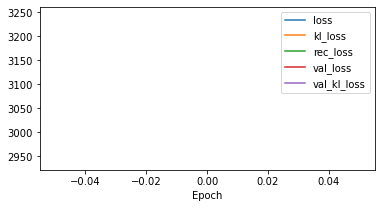

In [135]:
## Trenowanie dla danych syntetycznych

dkf = DKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=20)

history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')



In [136]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 50)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

fig, ax = plt.subplots(4, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

#################################################################################

ValueError: Expected parameter loc (Tensor of shape (100, 4)) of distribution MultivariateNormal(loc: torch.Size([100, 4]), covariance_matrix: torch.Size([100, 4, 4])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<ExpandBackward0>)

In [ ]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

## Haversine distance

In [190]:

def workout_to_haversine(i):
    ###Calculates haversine distance from point [0,0] in radians for a workout
    ###sklearn wants [lat,long] in radians
    ### to get distance in kilometers multiply by 6371000/1000 
    lat = np.asarray(data_endo[i]['latitude'])
    lon = np.asarray(data_endo[i]['longitude'])
    coords = np.column_stack([lat, lon])    
    coords_in_radians = np.radians(coords)
    zeros = np.zeros_like(coords_in_radians)
    zeros = np.radians(zeros)
    result = haversine_distances(coords_in_radians, zeros)
    result = result
    return result[:,0]


In [191]:

data = np.vstack( [workout_to_haversine(i) for i in range(5)]).T
#print(data.shape)
#print(data)

x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)


Epoch= 1/200, loss= 4.942, mse= 4.096, kld= 4.226
	val_loss= 4.287, val_mse= 3.690, val_kld= 2.987
Epoch= 2/200, loss= 4.520, mse= 3.914, kld= 3.030
	val_loss= 4.570, val_mse= 4.060, val_kld= 2.550
Epoch= 3/200, loss= 4.301, mse= 3.837, kld= 2.319
	val_loss= 3.776, val_mse= 3.414, val_kld= 1.806
Epoch= 4/200, loss= 3.932, mse= 3.559, kld= 1.867
	val_loss= 3.888, val_mse= 3.582, val_kld= 1.530
Epoch= 5/200, loss= 3.617, mse= 3.307, kld= 1.551
	val_loss= 3.286, val_mse= 3.045, val_kld= 1.209
Epoch= 6/200, loss= 3.385, mse= 3.133, kld= 1.258
	val_loss= 2.979, val_mse= 2.772, val_kld= 1.031
Epoch= 7/200, loss= 2.896, mse= 2.698, kld= 0.990
	val_loss= 2.748, val_mse= 2.595, val_kld= 0.767
Epoch= 8/200, loss= 2.940, mse= 2.776, kld= 0.821
	val_loss= 3.183, val_mse= 3.053, val_kld= 0.650
Epoch= 9/200, loss= 2.720, mse= 2.593, kld= 0.638
	val_loss= 2.562, val_mse= 2.464, val_kld= 0.492
Epoch= 10/200, loss= 2.638, mse= 2.536, kld= 0.514
	val_loss= 2.546, val_mse= 2.449, val_kld= 0.481
Epoch= 11

<AxesSubplot:xlabel='Epoch'>

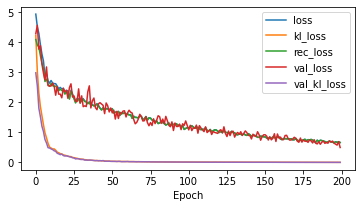

In [192]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

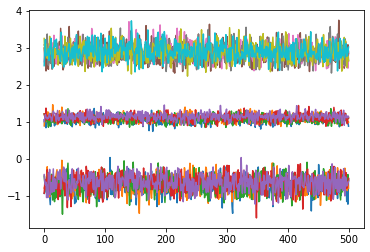

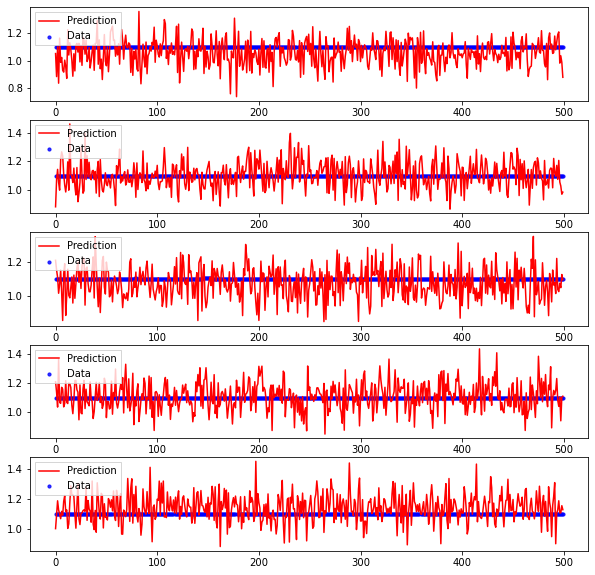

In [193]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    #axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
    #                facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [194]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

              MSE    R-squared       MAE
Average  0.010023 -89292.90716  0.079512
              MSE      R-squared       MAE
sample1  0.011493  -52767.745858  0.084681
sample2  0.009123  -90393.179570  0.075609
sample3  0.009941  -41867.742395  0.081651
sample4  0.009532  -95950.310447  0.077723
sample5  0.010026 -165485.557531  0.077897


## Haversine distance normalised to [0,100] for all data

In [195]:
data = np.vstack( [workout_to_haversine(i) for i in range(5)]).T
#print(data.shape)
data = NormalizeData(data)


x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)


Epoch= 1/200, loss= 3154.885, mse= 3043.510, kld= 1113.744
	val_loss= 3785.857, val_mse= 3776.506, val_kld= 93.508
Epoch= 2/200, loss= 3010.957, mse= 3004.739, kld= 62.185
	val_loss= 3755.072, val_mse= 3751.865, val_kld= 32.066
Epoch= 3/200, loss= 2992.979, mse= 2990.349, kld= 26.306
	val_loss= 3675.509, val_mse= 3673.294, val_kld= 22.141
Epoch= 4/200, loss= 2949.716, mse= 2947.703, kld= 20.130
	val_loss= 3595.534, val_mse= 3592.754, val_kld= 27.804
Epoch= 5/200, loss= 2878.413, mse= 2875.801, kld= 26.124
	val_loss= 3413.088, val_mse= 3408.729, val_kld= 43.589
Epoch= 6/200, loss= 2749.715, mse= 2745.634, kld= 40.807
	val_loss= 3112.207, val_mse= 3106.326, val_kld= 58.812
Epoch= 7/200, loss= 2534.514, mse= 2529.125, kld= 53.893
	val_loss= 2537.841, val_mse= 2529.947, val_kld= 78.935
Epoch= 8/200, loss= 2167.597, mse= 2161.817, kld= 57.795
	val_loss= 1485.063, val_mse= 1453.591, val_kld= 314.728
Epoch= 9/200, loss= 1493.996, mse= 1482.216, kld= 117.798
	val_loss= 4923.612, val_mse= 3156.

<AxesSubplot:xlabel='Epoch'>

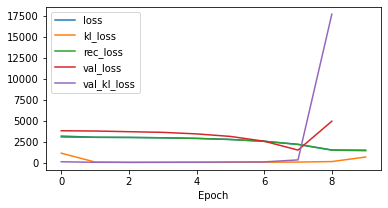

In [196]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

In [197]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)


ValueError: Expected parameter loc (Tensor of shape (100, 5)) of distribution MultivariateNormal(loc: torch.Size([100, 5]), covariance_matrix: torch.Size([100, 5, 5])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]], grad_fn=<ExpandBackward0>)

In [ ]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    #axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
    #                facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [ ]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

## Haversine distance normalised to [0,100] for every workout individually

In [205]:
data = np.vstack([NormalizeData(workout_to_haversine(i)) for i in range(5)]).T
#print(data.shape)
data = NormalizeData(data)

#print(data)

x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)



In [206]:

dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)


Epoch= 1/200, loss= 4723.926, mse= 4041.761, kld= 6821.648
	val_loss= 6020.017, val_mse= 5979.359, val_kld= 406.576
Epoch= 2/200, loss= 4011.500, mse= 3996.724, kld= 147.750
	val_loss= 5960.062, val_mse= 5938.575, val_kld= 214.869
Epoch= 3/200, loss= 3983.813, mse= 3971.826, kld= 119.876
	val_loss= 5876.442, val_mse= 5857.764, val_kld= 186.781
Epoch= 4/200, loss= 3932.533, mse= 3919.472, kld= 130.609
	val_loss= 5729.208, val_mse= 5691.893, val_kld= 373.148
Epoch= 5/200, loss= 3847.103, mse= 3825.597, kld= 215.057
	val_loss= 5517.739, val_mse= 5425.377, val_kld= 923.616
Epoch= 6/200, loss= 3691.194, mse= 3645.751, kld= 454.423
	val_loss= 5244.211, val_mse= 4713.966, val_kld= 5302.449
Epoch= 7/200, loss= 3642.133, mse= 3199.465, kld= 4426.688
	val_loss= 4790.456, val_mse= 4753.271, val_kld= 371.851
Epoch= 8/200, loss= 3300.760, mse= 3279.156, kld= 216.048
	val_loss= 4657.269, val_mse= 4644.546, val_kld= 127.229
Epoch= 9/200, loss= 3144.973, mse= 3135.179, kld= 97.941
	val_loss= 4399.154,

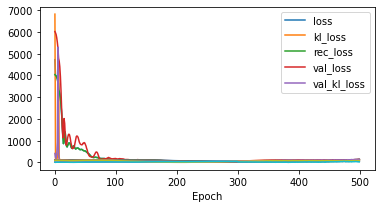

In [207]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)



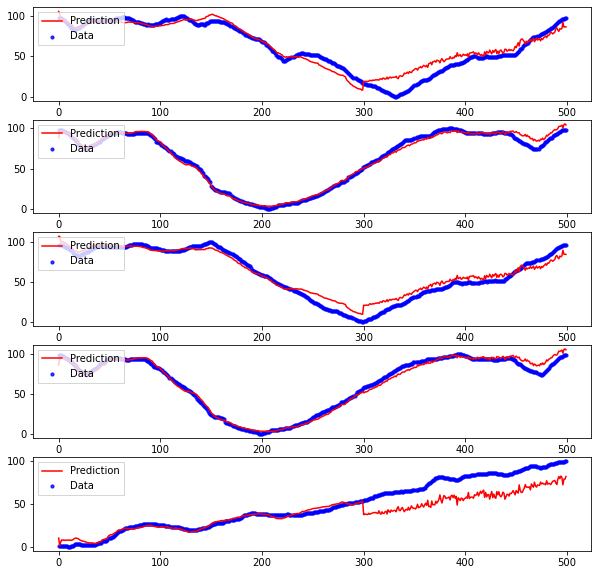

In [208]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    #axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
    #                facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [209]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared       MAE
Average  75.011246   0.915294  5.832477
                MSE  R-squared        MAE
sample1   77.399849   0.912768   6.820061
sample2   13.027984   0.988301   2.583862
sample3   54.149315   0.943922   6.066624
sample4   18.212990   0.983458   3.234309
sample5  212.266068   0.748021  10.457525


## Wodociągi Wrocławskie

In [210]:
#i = #examples
i = 7

In [211]:
df = pd.read_csv('water_consumption_profiles.csv')

In [212]:
_ = df.values

In [213]:
all_days = _[:,1:].T

In [214]:
all_days.shape

(144, 651)

In [215]:
all_days = all_days.astype('float64')

In [216]:
data = all_days[:, :7]

In [217]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:100]).reshape(1, 100, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[100:120]).reshape(1, 20, data.shape[1])
#print(x_val)



Epoch= 1/200, loss= 854.664, mse= 823.091, kld= 315.727
	val_loss= 1079.954, val_mse= 1075.681, val_kld= 42.732
Epoch= 2/200, loss= 810.318, mse= 807.146, kld= 31.728
	val_loss= 1012.673, val_mse= 1008.084, val_kld= 45.889
Epoch= 3/200, loss= 769.039, mse= 766.162, kld= 28.768
	val_loss= 860.445, val_mse= 853.857, val_kld= 65.879
Epoch= 4/200, loss= 676.982, mse= 672.580, kld= 44.014
	val_loss= 585.345, val_mse= 575.069, val_kld= 102.753
Epoch= 5/200, loss= 483.672, mse= 476.060, kld= 76.121
	val_loss= 245.996, val_mse= 230.889, val_kld= 151.071
Epoch= 6/200, loss= 225.761, mse= 212.992, kld= 127.692
	val_loss= 279.438, val_mse= 260.928, val_kld= 185.095
Epoch= 7/200, loss= 494.350, mse= 475.808, kld= 185.415
	val_loss= 79.698, val_mse= 71.579, val_kld= 81.188
Epoch= 8/200, loss= 113.970, mse= 109.256, kld= 47.141
	val_loss= 43.662, val_mse= 36.596, val_kld= 70.654
Epoch= 9/200, loss= 76.684, mse= 72.514, kld= 41.694
	val_loss= 81.864, val_mse= 74.661, val_kld= 72.033
Epoch= 10/200, lo

<AxesSubplot:xlabel='Epoch'>

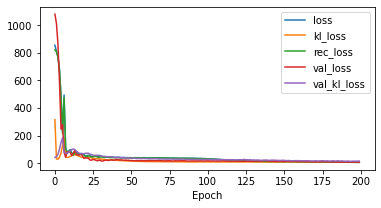

In [218]:

dkf = DKF(input_dim=i, z_dim=5*i, rnn_dim=5*i, trans_dim=5*i, emission_dim=5*i)

history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

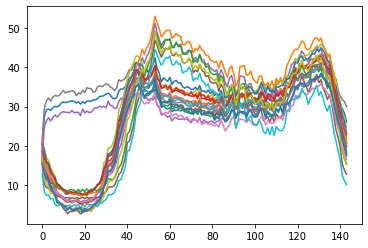

In [219]:

# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 50)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)


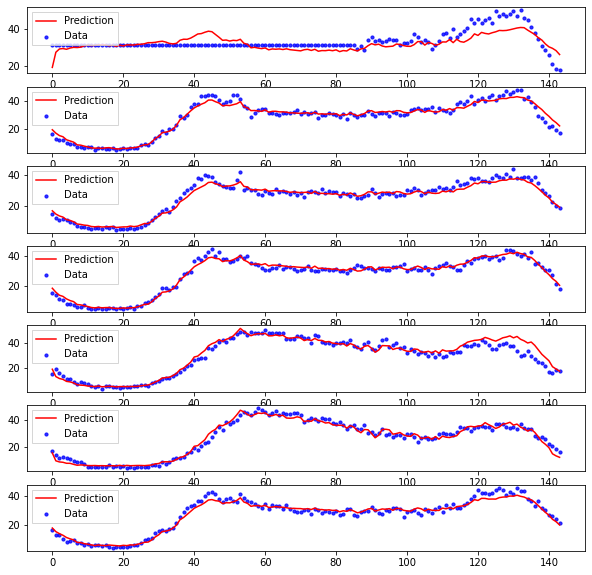

In [220]:
fig, ax = plt.subplots(i, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    #axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
    #                facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [221]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)


              MSE  R-squared       MAE
Average  8.213281   0.882979  2.087006
               MSE  R-squared       MAE
sample1  17.997593   0.435380  3.228889
sample2   6.945573   0.956110  1.933151
sample3   5.522521   0.953048  1.791395
sample4   3.627149   0.973916  1.515923
sample5  12.751308   0.934164  2.465559
sample6   5.035285   0.970122  1.829517
sample7   5.613532   0.958111  1.844606
